In [1]:
import pandas as pd
import numpy as np

#Plots
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
#Nicer style
style.use('seaborn') 

#Wordcloud
from wordcloud import WordCloud, STOPWORDS

#Work with text
from nltk.tokenize import RegexpTokenizer
import re #regexp
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer 




#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

import random

# Fake news corpus
## Descripción del dataset

El dataset descargado es [Fake News Corpus](https://github.com/several27/FakeNewsCorpus). 
Este es un dataset abierto que se sigue actualizando dirariamente en base a los datos de [OpenSources.co](http://www.opensources.co/), que es una lista de noticias etiquetadas por un equipo de investigadores de la Univerisdad Merrimack. Hay 12 categorías y son las siguientes:

* **Fake News (tag fake)** Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports

* **Satire (tag satire)** Sources that use humor, irony, exaggeration, ridicule, and false information to comment on current events.

* **Extreme Bias (tag bias)** Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts.

* **Conspiracy Theory (tag conspiracy):** Sources that are well-known promoters of kooky conspiracy theories.

* **Rumor Mill (tag rumor)** Sources that traffic in rumors, gossip, innuendo, and unverified claims.

* **State News (tag state)** Sources in repressive states operating under government sanction.

* **Junk Science (tag junksci)** Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims.

* **Hate News (tag hate)** Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination.

* **Clickbait (tag clickbait)** Sources that provide generally credible content, but use exaggerated, misleading, or questionable headlines, social media descriptions, and/or images.

* **Proceed With Caution (tag unreliable)** Sources that may be reliable but whose contents require further verification.

* **Political (tag political)** Sources that provide generally verifiable information in support of certain points of view or political orientations.

* **Credible (tag reliable)** Sources that circulate news and information in a manner consistent with traditional and ethical practices in journalism (Remember: even credible sources sometimes rely on clickbait-style headlines or occasionally make mistakes. No news organization is perfect, which is why a healthy news diet consists of multiple sources of information).

La versión usada en este trabajo tiene **8.529.194 entradas** y pesa **27GB**


### Cargamos las primeras 20.000 filas del dataset.

In [9]:
news = pd.read_csv('../../data/news_sampled.csv', nrows=90000)
#Select only relevant columns
news = news[['type', 'content', 'title']]
#Remove columns with NaNs 
news = news.dropna()

*Convertir tags la división usada*

In [10]:
def convert_tag(tag):
    """Convierte un tag a uno de tres grupos (fake, truth, clickbait)"""
    new_tag = None
    #fake = set(['conspiracy', 'junksci', 'rumor', 'unknown', 'satire', 'hate', 'unreliable', 'fake'])
    fake = set(['fake'])
    truth = set(['reliable', 'political'])
    click = set(['clickbait'])
    bias = set(['bias'])
    
    if tag in fake:
        new_tag = 'fake'
    if tag in truth:
        new_tag = 'truth'
    if tag in click:
        new_tag = 'click'
    if tag in bias:
        new_tag = 'bias'
        
    return new_tag

In [11]:
news['type'] = news.swifter.apply(lambda row: convert_tag(row['type']), axis=1)

Pandas Apply: 100%|██████████| 81252/81252 [00:01<00:00, 68045.24it/s]


In [12]:
news.head(3)

,type,content,title
0,None,"Life is an illusion, at least on a quantum lev...",Is life an ILLUSION? Researchers prove 'realit...
1,None,"“When the police finally left the campus, arou...",Black Agenda Report
2,None,\n\nSpeaking Engagement Request\n\n\n\nContact...,Request Speaking Engagement


### Número de noticias por tipo

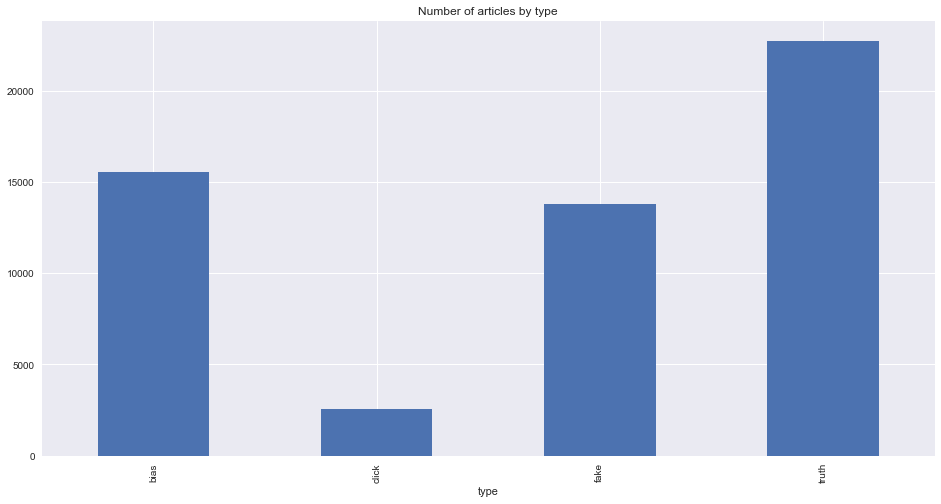

In [13]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.groupby("type").count()['content'].plot.bar(title = "Number of articles by type", ax = ax)

El grupo fake está claramente sobrerrepresentado en el dataset, mientras que el que menos elementos tiene es el grupo *clickbait*

# Análisis lingüístico

Funciones auxiliares

In [14]:
stop_words = STOPWORDS.union(set(["will"]))
ps = PorterStemmer()

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]    
    
    return ' '.join(words)


def clean_text_array(text):
    """ Lo mismo que clean_text pero retorna un array
    """
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]  
    return words


def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    return tokens


def split_phrases(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = '. '.join(text.split("\n")).split(".")
    text = [x for x in text if x not in [".", "\n", "", " "]]
    return text

### Palabras más frecuentes por tipo de noticia

#### En el título

In [15]:
corpus_text = [clean_text_array(i) for i in news[news['type'] == 'fake']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in news[news['type'] == 'click']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_click = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'truth']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'bias']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_bias= c.most_common(20)

In [16]:
most_common_bias

[('investmentwatch', 2237),
 ('us', 755),
 ('trump', 680),
 ('news', 554),
 ('archives', 546),
 ('blog', 462),
 ('russia', 448),
 ('life', 397),
 ('obama', 396),
 ('conscious', 341),
 ('new', 332),
 ('cln', 326),
 ('russian', 305),
 ('video', 297),
 ('pages', 266),
 ('link', 265),
 ('war', 260),
 ('syria', 227),
 ('hillary', 204),
 ('channels', 197)]

In [17]:
most_common_truth

[('daily', 2410),
 ('kos', 2211),
 ('trump', 1171),
 ('articles', 824),
 ('obama', 689),
 ('magazine', 666),
 ('profile', 520),
 ('people', 511),
 ('new', 502),
 ('comments', 481),
 ('followed', 471),
 ('national', 412),
 ('review', 336),
 ('news', 318),
 ('favorite', 313),
 ('issue', 311),
 ('liberty', 309),
 ('archives', 304),
 ('voice', 303),
 ('blogs', 300)]

In [18]:
most_common_fake

[('new', 525),
 ('market', 440),
 ('us', 326),
 ('post', 321),
 ('trump', 310),
 ('internet', 303),
 ('obama', 279),
 ('dc', 266),
 ('gold', 254),
 ('gazette', 253),
 ('world', 216),
 ('report', 204),
 ('video', 200),
 ('america', 191),
 ('u', 190),
 ('news', 188),
 ('global', 181),
 ('blog', 166),
 ('time', 164),
 ('now', 155)]

In [19]:
most_common_click

[('portal', 556),
 ('archives', 355),
 ('trump', 240),
 ('new', 77),
 ('us', 68),
 ('video', 60),
 ('abortion', 54),
 ('obama', 54),
 ('pro', 52),
 ('clinton', 50),
 ('donald', 46),
 ('says', 44),
 ('gop', 44),
 ('hillary', 44),
 ('watch', 43),
 ('u', 36),
 ('man', 36),
 ('police', 35),
 ('isis', 35),
 ('planned', 34)]

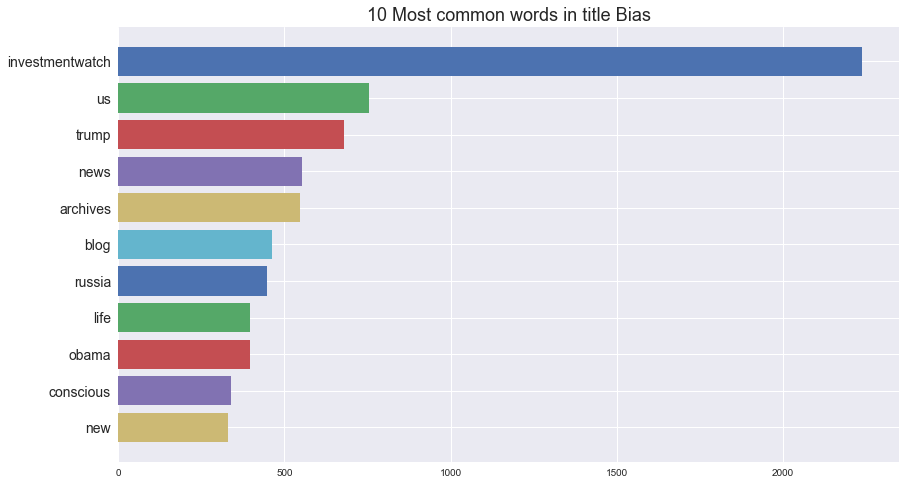

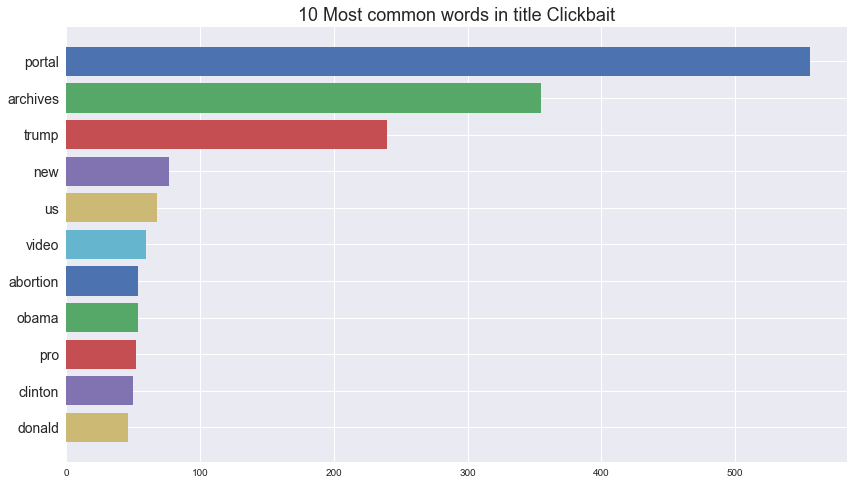

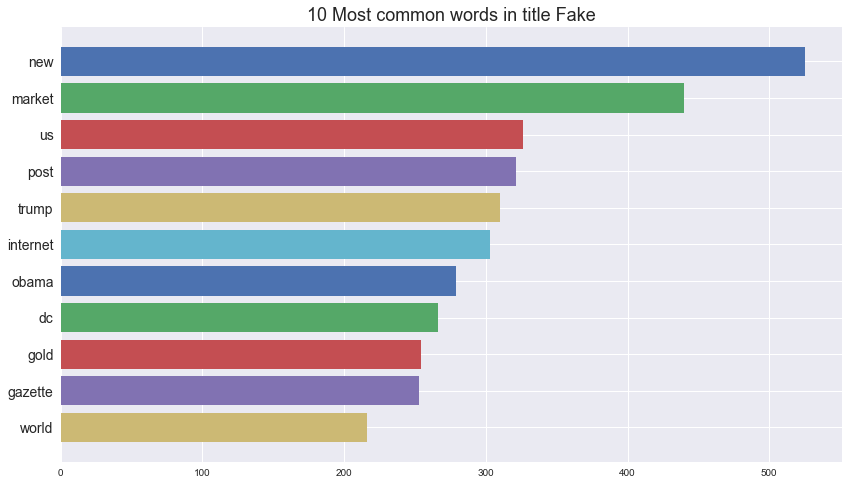

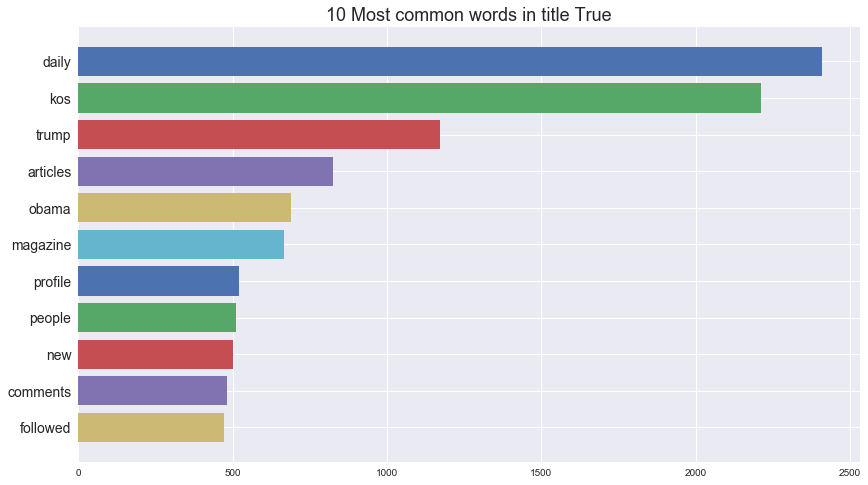

In [20]:
names = ["10 Most common words in title Bias", "10 Most common words in title Clickbait", "10 Most common words in title Fake", "10 Most common words in title True"]
variables = [most_common_bias, most_common_click, most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

__Análisis de tri-grams__

In [21]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'fake']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [22]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'truth']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

In [23]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'click']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_click = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_click[ng_text] = ng_count

In [24]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'bias']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_bias = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_bias[ng_text] = ng_count

In [25]:
print("TRIGRAMS BIAS")
ngrams_bias

TRIGRAMS BIAS


{'conscious life news': 338,
 'cln conscious life': 326,
 'that link to': 262,
 'pages that link': 262,
 'the unz review': 79,
 'changes related to': 74,
 'patriotic immigration reform': 54,
 'vdare premier news': 53,
 'premier news outlet': 53,
 'outlet for patriotic': 53,
 'news outlet for': 53,
 'for patriotic immigration': 53,
 'статьи новости по': 35,
 'новости по тэгу': 35,
 'home page from': 31,
 'archived antiwar home': 31,
 'antiwar home page': 31,
 'for security policy': 30,
 'center for security': 30,
 'paul craig roberts': 23,
 'user contributions for': 18,
 'usa politics today': 18,
 'the independent archive': 15,
 'the united states': 14,
 'центр катехон геополитика': 12,
 'катехон геополитика традиция': 12,
 'аналитический центр катехон': 12,
 'presidential horse race': 12,
 'of the world': 12,
 'in the world': 12}

In [26]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'daily kos comments': 414,
 'kos comments by': 370,
 'guardian liberty voice': 292,
 'current issue magazine': 276,
 'posting history for': 192,
 'the daily caller': 176,
 'kos blogroll for': 153,
 'daily kos blogroll': 153,
 'at daily kos': 133,
 'national review online': 123,
 'archives page of': 108,
 'of guardian liberty': 65,
 'page of guardian': 64,
 'baptist news global': 55,
 'voice page of': 48,
 'liberty voice page': 48,
 'author at guardian': 48,
 'at guardian liberty': 48,
 'daily kos elections': 47,
 'kos comments rated': 44,
 'comments rated by': 44,
 'recent replies to': 43,
 'kos recent replies': 43,
 'daily kos recent': 43,
 'the ron paul': 32,
 'ron paul institute': 32,
 'peace and prosperity': 31,
 'paul institute for': 31,
 'institute for peace': 31,
 'for peace and': 31}

In [27]:
print("TRIGRAMS FAKE")
ngrams_fake

TRIGRAMS FAKE


{'the internet post': 274,
 'archives dc gazette': 79,
 'stories contributed by': 38,
 'of the day': 27,
 'the united states': 23,
 'the ipo buzz': 22,
 'new at reason': 22,
 'trading watch list': 18,
 'the truth about': 18,
 'market research report': 18,
 'cooking and recipes': 18,
 'tale of the': 15,
 'of the year': 15,
 'how to make': 15,
 'and forecast to': 15,
 'the daily dab': 14,
 'science and technology': 14,
 'quick hit on': 14,
 'on cannabis stocks': 14,
 'of the tape': 14,
 'hit on cannabis': 14,
 'daily dab quick': 14,
 'dab quick hit': 14,
 'you need to': 13,
 'new world order': 13,
 'it time to': 13,
 'comments business outlook': 13,
 'what is the': 12,
 'trends and forecast': 12,
 'through my bible': 12}

In [28]:
print("TRIGRAMS CLICK")
ngrams_click

TRIGRAMS CLICK


{'march for life': 5,
 'you need to': 4,
 'the pro generation': 4,
 'out of the': 4,
 'of the year': 4,
 'trump campaign manager': 3,
 'the truth about': 3,
 'the christian right': 3,
 'supreme court ruling': 3,
 'south china sea': 3,
 'over south china': 3,
 'new world order': 3,
 'need to know': 3,
 'jeff sessions as': 3,
 'is going to': 3,
 'if clinton wins': 3,
 'donald trump archives': 3,
 'child sex abuse': 3,
 'author at politicus': 3,
 'at politicus usa': 3,
 'you won believe': 2,
 'you never guess': 2,
 'word of the': 2,
 'won go down': 2,
 'won believe what': 2,
 'with one photo': 2,
 'with nuns on': 2,
 'why did the': 2,
 'who has come': 2,
 'when discussing poisoned': 2}

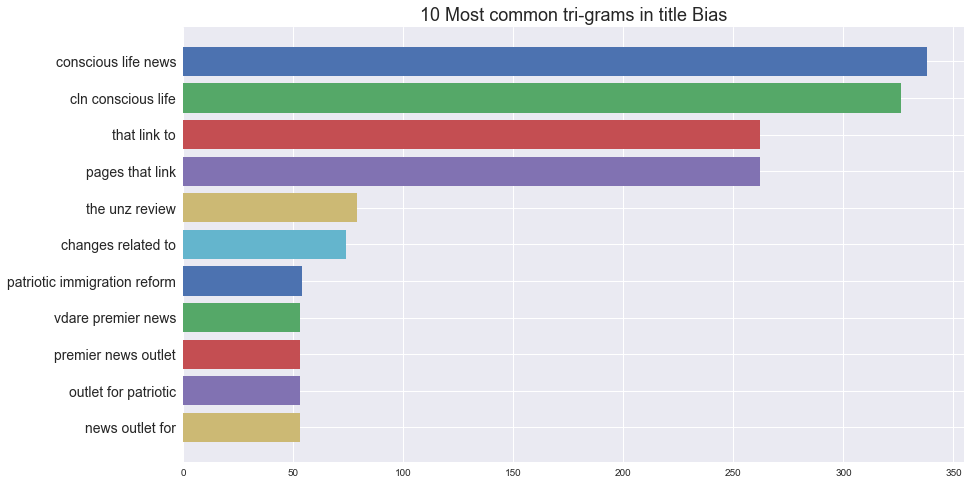

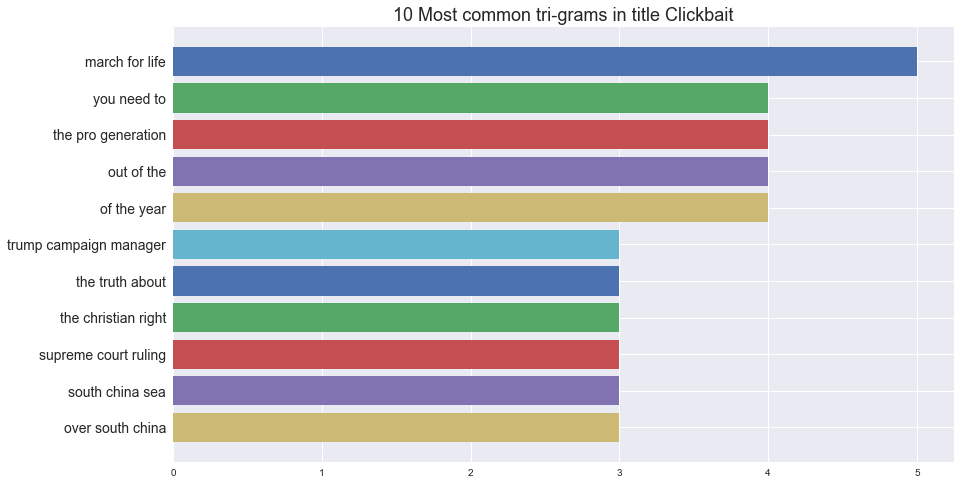

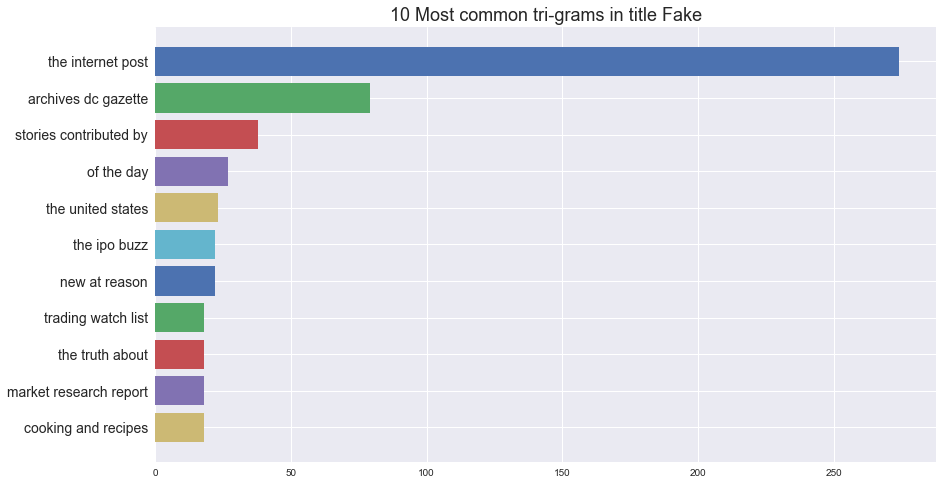

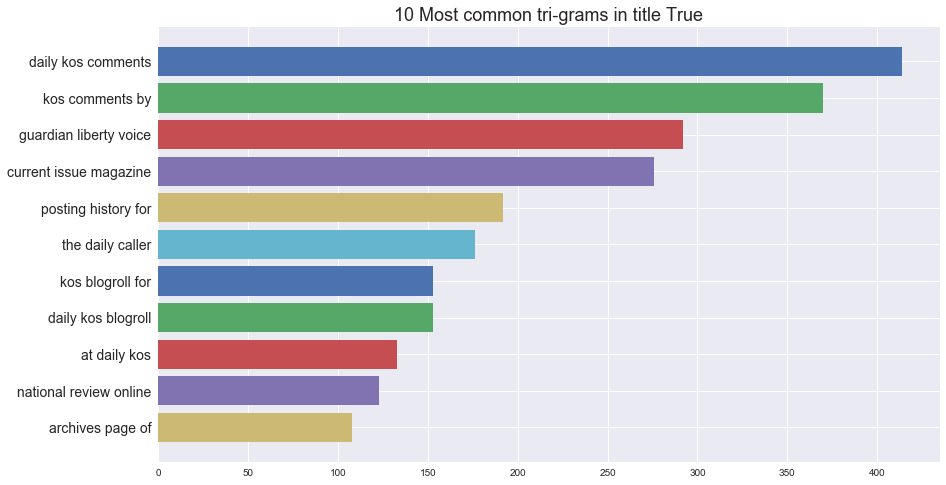

In [29]:
names = ["10 Most common tri-grams in title Bias", "10 Most common tri-grams in title Clickbait", "10 Most common tri-grams in title Fake", "10 Most common tri-grams in title True"]
variables = [ngrams_bias, ngrams_click, ngrams_fake, ngrams_true]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    idx = 0
    for index, item in var.items():
        if idx > 10: break
        ax.barh(width=item, y=index)
        ax.invert_yaxis()
        idx += 1
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

**Wordclouds for titles**

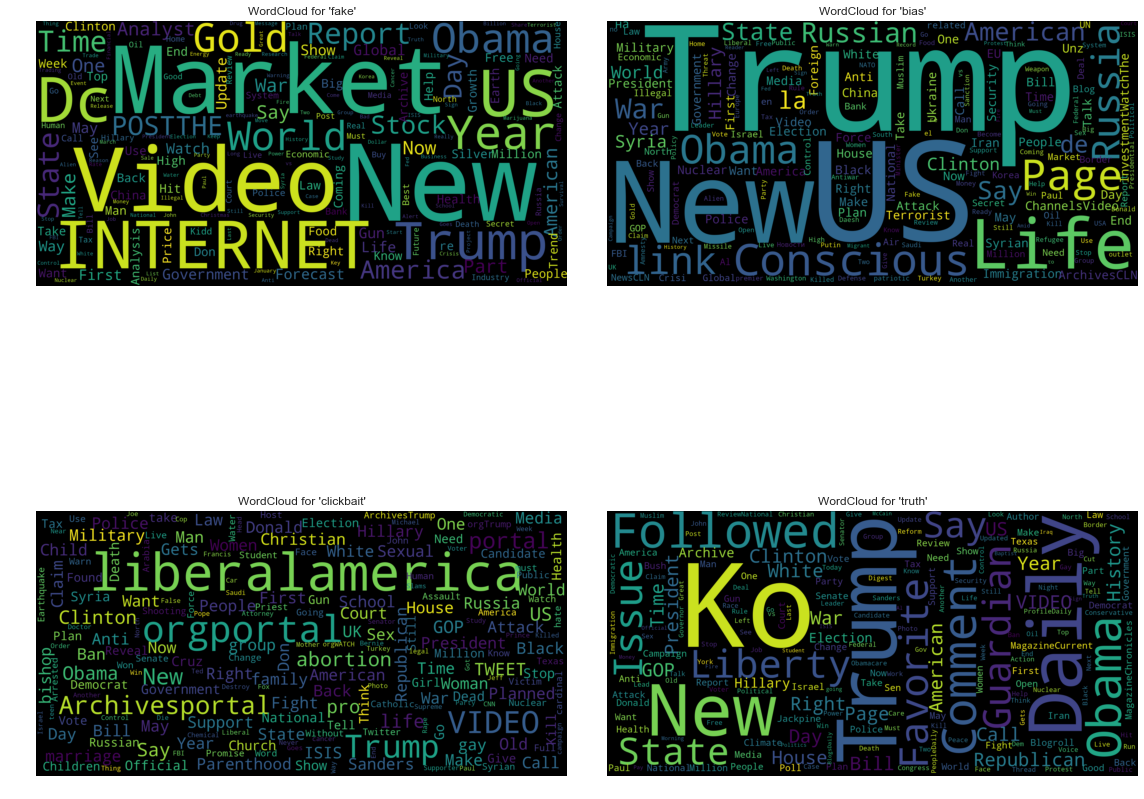

In [30]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

corpus_text = ''.join(news[news['type'] == 'fake']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0,0].imshow(wordcloud, interpolation='bilinear')
ax[0,0].axis("off")
ax[0,0].set_title("WordCloud for 'fake'")


corpus_text = ''.join(news[news['type'] == 'bias']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0,1].imshow(wordcloud, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title("WordCloud for 'bias'")


corpus_text = ''.join(news[news['type'] == 'click']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1,0].imshow(wordcloud, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title("WordCloud for 'clickbait'")


corpus_text = ''.join(news[news['type'] == 'truth']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1,1].imshow(wordcloud, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title("WordCloud for 'truth'")

plt.tight_layout()

#### En el contenido

In [31]:
stop_words = STOPWORDS.union(set(["will", "one", "new"])) #Most common words in all

In [32]:
corpus_text = [clean_text_array(i) for i in news[news['type'] == 'fake']['content'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in news[news['type'] == 'click']['content'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_click = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'truth']['content'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)


corpus_text = [clean_text_array(i) for i in news[news['type'] == 'bias']['content'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_bias= c.most_common(20)

In [33]:
most_common_bias

[('us', 20433),
 ('people', 14502),
 ('said', 14220),
 ('de', 13797),
 ('war', 11937),
 ('government', 11850),
 ('use', 10377),
 ('american', 10304),
 ('state', 10152),
 ('trump', 9958),
 ('la', 9747),
 ('now', 9631),
 ('president', 9458),
 ('even', 9275),
 ('в', 9155),
 ('world', 9102),
 ('russia', 8454),
 ('time', 8419),
 ('may', 8380),
 ('obama', 8334)]

In [34]:
most_common_truth

[('recs', 36077),
 ('trump', 33982),
 ('people', 27830),
 ('said', 26115),
 ('president', 21521),
 ('state', 20600),
 ('now', 18915),
 ('time', 18565),
 ('us', 17081),
 ('even', 16562),
 ('obama', 16203),
 ('first', 15896),
 ('u', 15881),
 ('many', 15777),
 ('government', 15160),
 ('last', 13988),
 ('years', 13971),
 ('may', 13855),
 ('two', 13799),
 ('house', 12999)]

In [35]:
most_common_fake

[('blockchain', 22546),
 ('people', 15728),
 ('trump', 15595),
 ('next', 14499),
 ('us', 13127),
 ('stocks', 12795),
 ('bitcoin', 12011),
 ('time', 11655),
 ('headline', 11390),
 ('searches', 11318),
 ('exceed', 11311),
 ('market', 11218),
 ('two', 11117),
 ('now', 10474),
 ('source', 9861),
 ('said', 9719),
 ('many', 9400),
 ('think', 9046),
 ('world', 8843),
 ('even', 8551)]

In [36]:
most_common_click

[('trump', 4040),
 ('said', 3025),
 ('people', 2329),
 ('president', 1918),
 ('us', 1442),
 ('state', 1370),
 ('time', 1352),
 ('donald', 1301),
 ('now', 1250),
 ('even', 1225),
 ('many', 1111),
 ('right', 1065),
 ('women', 1051),
 ('twitter', 1049),
 ('republican', 1035),
 ('first', 1024),
 ('may', 1013),
 ('facebook', 1003),
 ('two', 993),
 ('news', 969)]

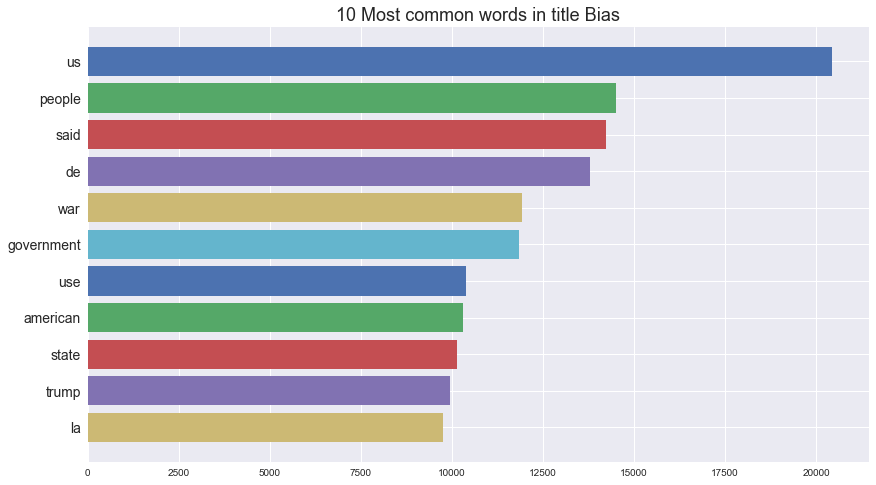

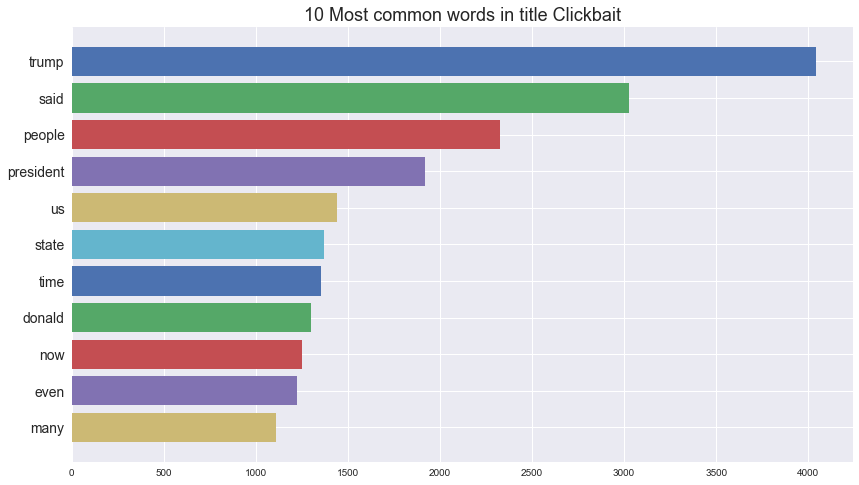

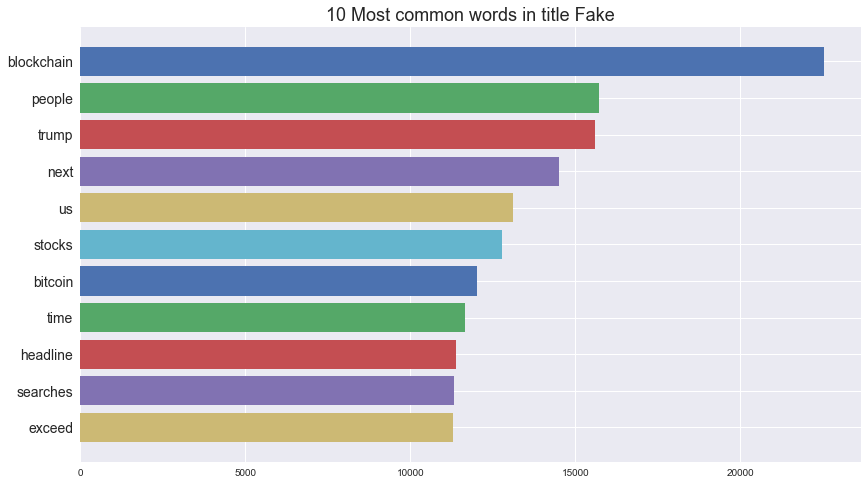

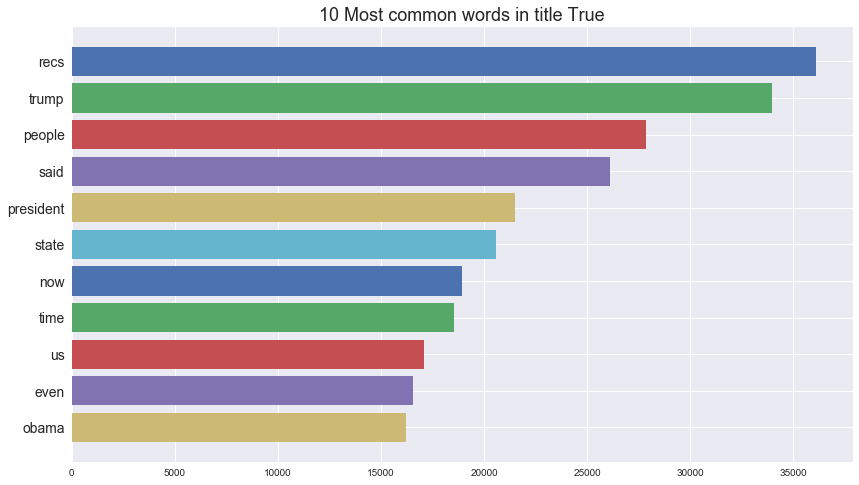

In [37]:
names = ["10 Most common words in title Bias", "10 Most common words in title Clickbait", "10 Most common words in title Fake", "10 Most common words in title True"]
variables = [most_common_bias, most_common_click, most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

#### Tri-grams más usados

In [38]:
news_lite = news.head(8000) #Version reducida para que no tarde tanto

In [39]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'fake']['content'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [40]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'truth']['content'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

In [41]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'click']['content'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_click = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_click[ng_text] = ng_count

In [42]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'bias']['content'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_bias = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_bias[ng_text] = ng_count

In [43]:
print("TRIGRAMS BIAS")
ngrams_bias

TRIGRAMS BIAS


{'the united states': 96,
 'one of the': 70,
 'as well as': 40,
 'the rest of': 39,
 'the new york': 37,
 'new york times': 37,
 'in order to': 35,
 'the white house': 33,
 'out of the': 32,
 'of the us': 32,
 'we are not': 29,
 'there is no': 29,
 'of the world': 29,
 'of the most': 28,
 'the end of': 25,
 'that the us': 25,
 'the fact that': 24,
 'is that the': 24,
 'of planned parenthood': 23,
 'the us and': 22,
 'that it is': 22,
 'most of the': 22,
 'are calling for': 22,
 'we are calling': 21,
 'rest of the': 21,
 'in this country': 21,
 'the number of': 20,
 'the middle east': 20,
 'the federal government': 20,
 'part of the': 20}

In [44]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'the united states': 418,
 'one of the': 270,
 'the white house': 264,
 'according to the': 209,
 'the trump administration': 169,
 'the department of': 166,
 'as well as': 160,
 'the washington examiner': 156,
 'the end of': 135,
 'in order to': 132,
 'part of the': 127,
 'in the united': 121,
 'the federal government': 119,
 'some of the': 116,
 'the fact that': 109,
 'out of the': 101,
 'the obama administration': 94,
 'be able to': 93,
 'of the united': 81,
 'the number of': 79,
 'percent of the': 79,
 'there is no': 78,
 'in the country': 76,
 'going to be': 76,
 'president donald trump': 75,
 'new york times': 74,
 'members of the': 74,
 'the supreme court': 73,
 'of the house': 73,
 'of the most': 70}

In [45]:
print("TRIGRAMS FAKE")
ngrams_fake

TRIGRAMS FAKE


{'trump blockchain stocks': 3984,
 'stocks are next': 3984,
 'searches exceed trump': 3984,
 'headline bitcoin blockchain': 3984,
 'exceed trump blockchain': 3984,
 'blockchain stocks are': 3984,
 'blockchain searches exceed': 3984,
 'bitcoin blockchain searches': 3984,
 'this story is': 1744,
 'your two cents': 1739,
 'add your two': 1739,
 'think this story': 1738,
 'story is fact': 1738,
 'readers think this': 1738,
 'of readers think': 1738,
 'is fact add': 1738,
 'fact add your': 1738,
 'two cents headline': 1716,
 'cents headline bitcoin': 1716,
 'the united states': 1013,
 'one of the': 992,
 'as well as': 719,
 'appeared first on': 506,
 'according to the': 458,
 'some of the': 439,
 'in order to': 438,
 'of the world': 388,
 'the end of': 372,
 'are next by': 364,
 'out of the': 360}

In [46]:
print("TRIGRAMS CLICK")
ngrams_click

TRIGRAMS CLICK


{'the white house': 29,
 'featured image via': 15,
 'the united states': 14,
 'according to the': 14,
 'the trump administration': 12,
 'one of the': 9,
 'via getty images': 7,
 'image via getty': 7,
 'donald trump january': 7,
 'wall street journal': 6,
 'percent of the': 6,
 'of the united': 6,
 'new york times': 6,
 'kim jong un': 6,
 'featured image by': 6,
 'with kim jong': 5,
 'the washington post': 5,
 'the trump campaign': 5,
 'the supreme court': 5,
 'the obama administration': 5,
 'the new york': 5,
 'the case of': 5,
 'that the president': 5,
 'that he was': 5,
 'relationship with kim': 5,
 'our lady of': 5,
 'of the trump': 5,
 'of the state': 5,
 'member of the': 5,
 'in the world': 5}

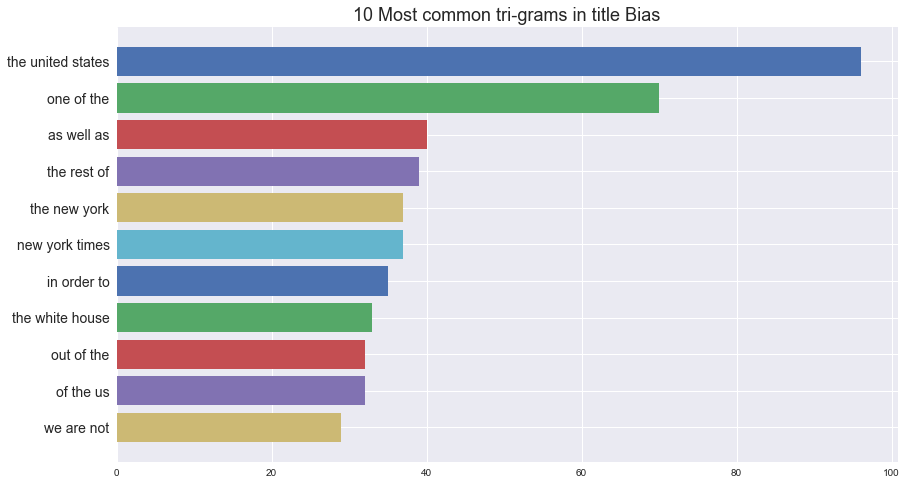

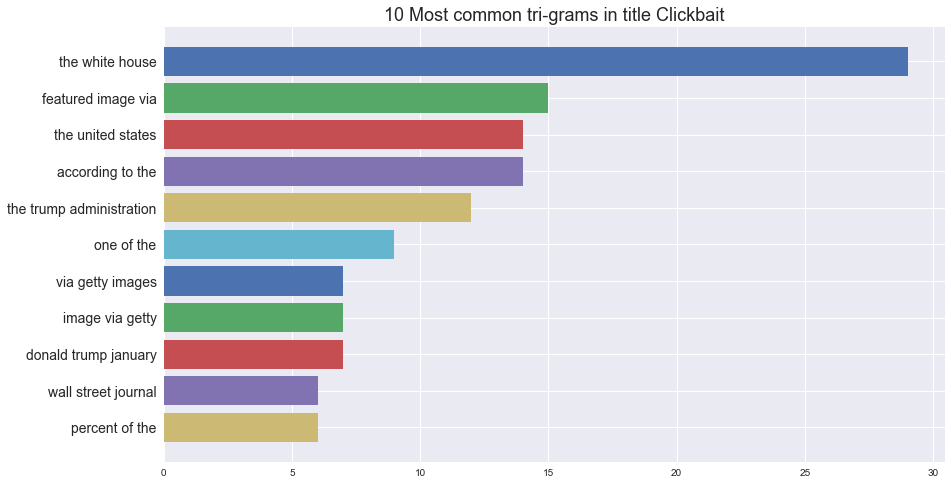

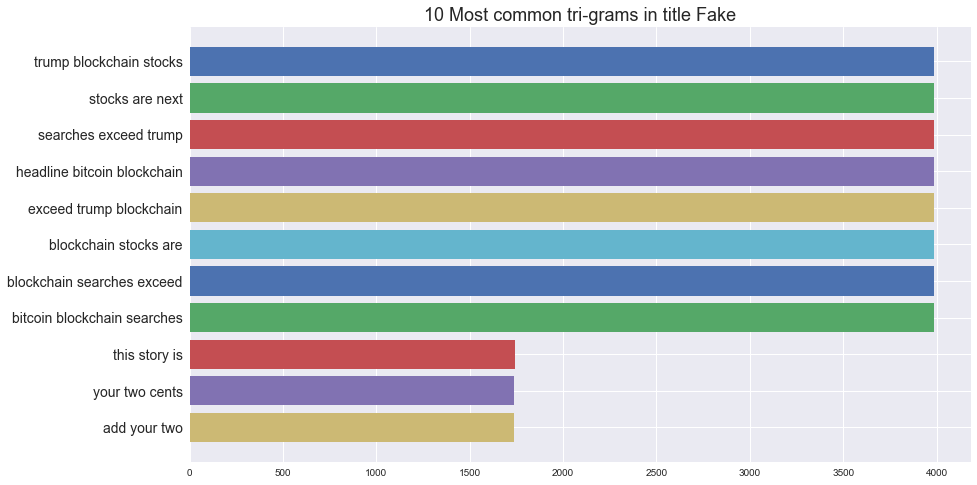

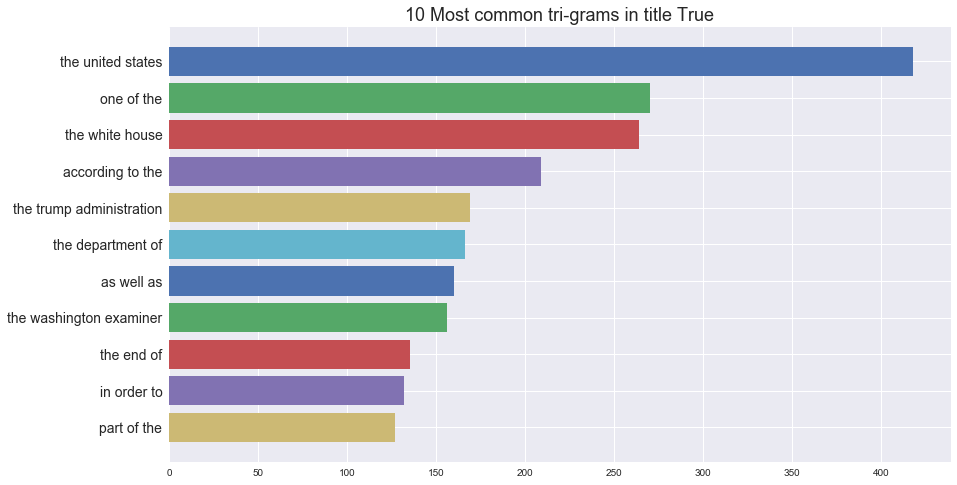

In [47]:
names = ["10 Most common tri-grams in title Bias", "10 Most common tri-grams in title Clickbait", "10 Most common tri-grams in title Fake", "10 Most common tri-grams in title True"]
variables = [ngrams_bias, ngrams_click, ngrams_fake, ngrams_true]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    idx = 0
    for index, item in var.items():
        if idx > 10: break
        ax.barh(width=item, y=index)
        ax.invert_yaxis()
        idx += 1
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

Text(0.5,1,"WordCloud for 'truth'")

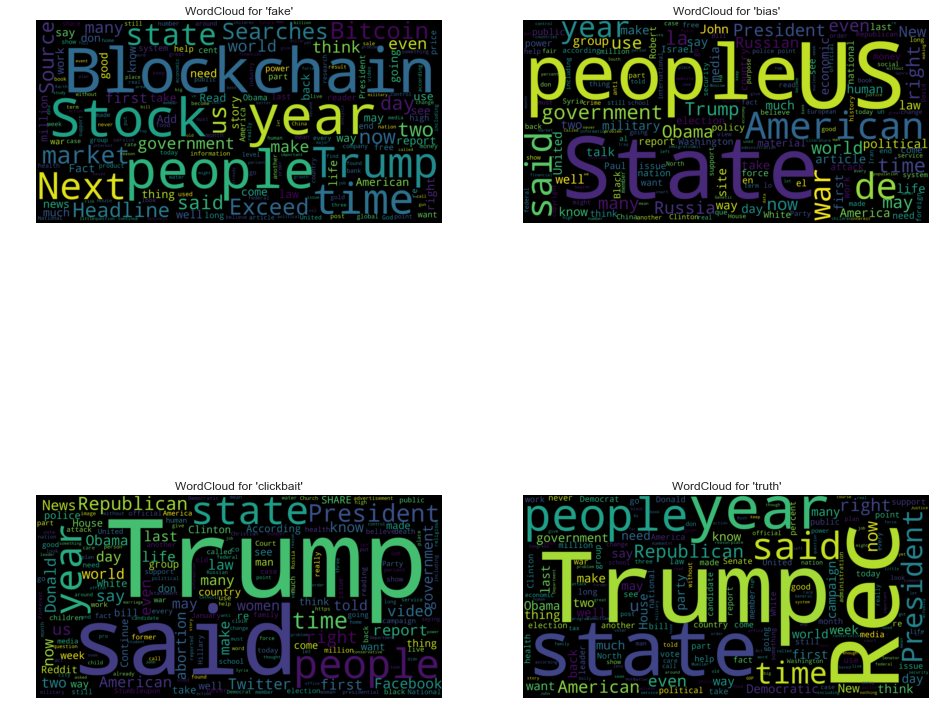

In [48]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

corpus_text = ''.join(news[news['type'] == 'fake']['content'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0,0].imshow(wordcloud, interpolation='bilinear')
ax[0,0].axis("off")
ax[0,0].set_title("WordCloud for 'fake'")




corpus_text = ''.join(news[news['type'] == 'bias']['content'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0,1].imshow(wordcloud, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title("WordCloud for 'bias'")


corpus_text = ''.join(news[news['type'] == 'click']['content'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1,0].imshow(wordcloud, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title("WordCloud for 'clickbait'")


corpus_text = ''.join(news[news['type'] == 'truth']['content'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1,1].imshow(wordcloud, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title("WordCloud for 'truth'")

**Longitud en palabras de las noticias**

Para ello, hay que tokenizar y limpiar el texto

In [49]:
news['clean_content'] = news.swifter.apply(lambda row: clean_text(row['content']), axis=1)
news['clean_title'] = news.swifter.apply(lambda row: clean_text(row['title']), axis=1)

Pandas Apply: 100%|██████████| 81252/81252 [00:01<00:00, 41045.26it/s]


In [50]:
news['len_content'] = news.swifter.apply(lambda row: len(row['clean_content']), axis=1)

Pandas Apply: 100%|██████████| 81252/81252 [00:01<00:00, 74185.28it/s]


Text(0.5,0.98,'')

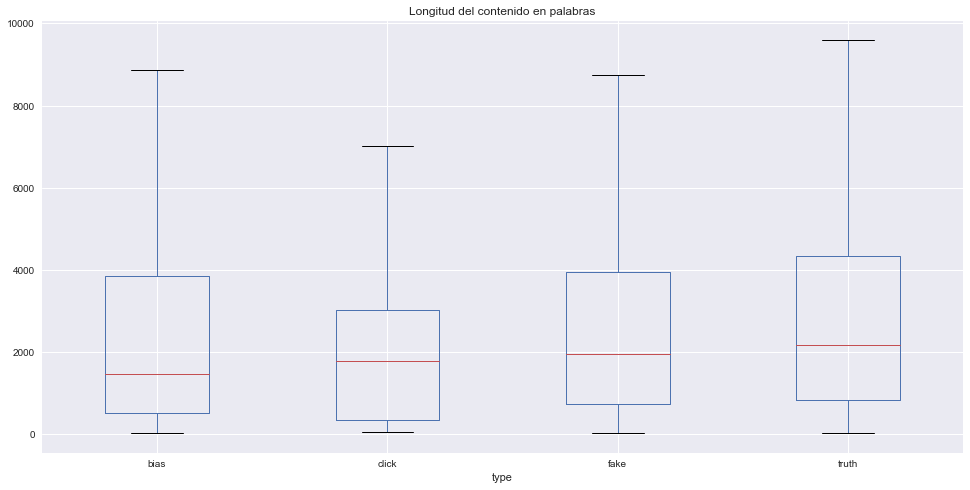

In [51]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Longitud del contenido en palabras")
plt.suptitle("")

In [52]:
news = news.drop(["clean_content", "clean_title","len_content"], axis=1)

**Longitud media de las frases**



In [53]:
corpus_text = '. '.join([i for i in news[news['type'] == 'fake']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_fake = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in news[news['type'] == 'truth']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_truth = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in news[news['type'] == 'click']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_click = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in news[news['type'] == 'bias']['content'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_bias = [len(tokenize(s)) for s in corpus_text]

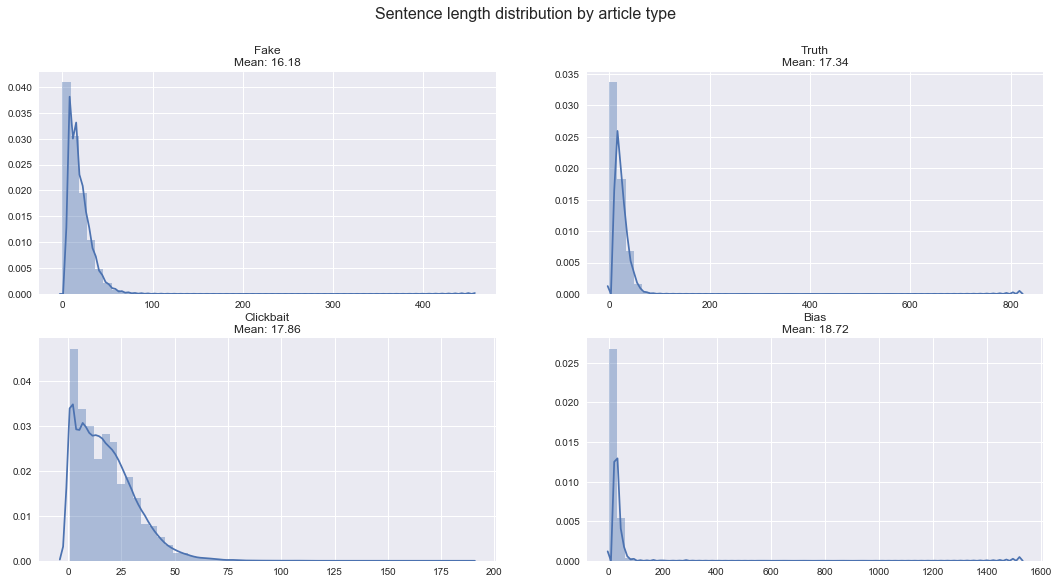

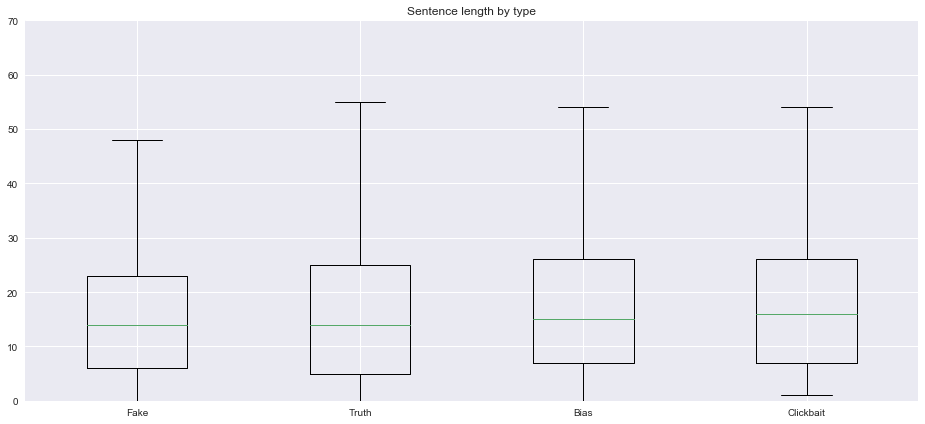

In [54]:
fig, ax = plt.subplots(2,2, figsize=(18,9))
fig.suptitle("Sentence length distribution by article type", size=16)

sns.distplot(lengths_fake, ax=ax[0,0])
ax[0,0].set_title("Fake\nMean: {0:.2f}".format(np.average(lengths_fake)))


sns.distplot(lengths_truth, ax=ax[0,1])
ax[0,1].set_title("Truth\nMean: {0:.2f}".format(np.average(lengths_truth)))

sns.distplot(lengths_click, ax=ax[1,0])
ax[1,0].set_title("Clickbait\nMean: {0:.2f}".format(np.average(lengths_click)))

sns.distplot(lengths_bias, ax=ax[1,1])
ax[1,1].set_title("Bias\nMean: {0:.2f}".format(np.average(lengths_bias)))

plt.show()


#Boxplot
fig, ax = plt.subplots(1,1, figsize=(16,7))
plt.title("Sentence length by type")
plt.ylim((0,70))
plt.boxplot([lengths_fake, lengths_truth, lengths_bias, lengths_click], 
            labels=['Fake', 'Truth', 'Bias', 'Clickbait'])
plt.show()

**Longitud en frases de las noticias**

In [113]:
news['len_content'] = news.swifter.apply(lambda row: len(row['content'].split(". ")), axis=1)

Pandas Apply: 100%|██████████| 81252/81252 [00:01<00:00, 42688.50it/s]


Text(0.5,0.98,'')

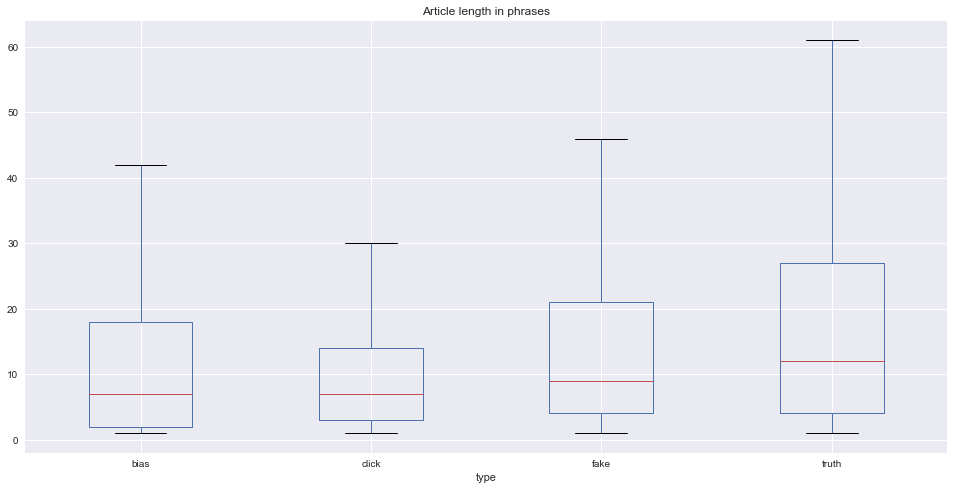

In [114]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Article length in phrases")
plt.suptitle("")

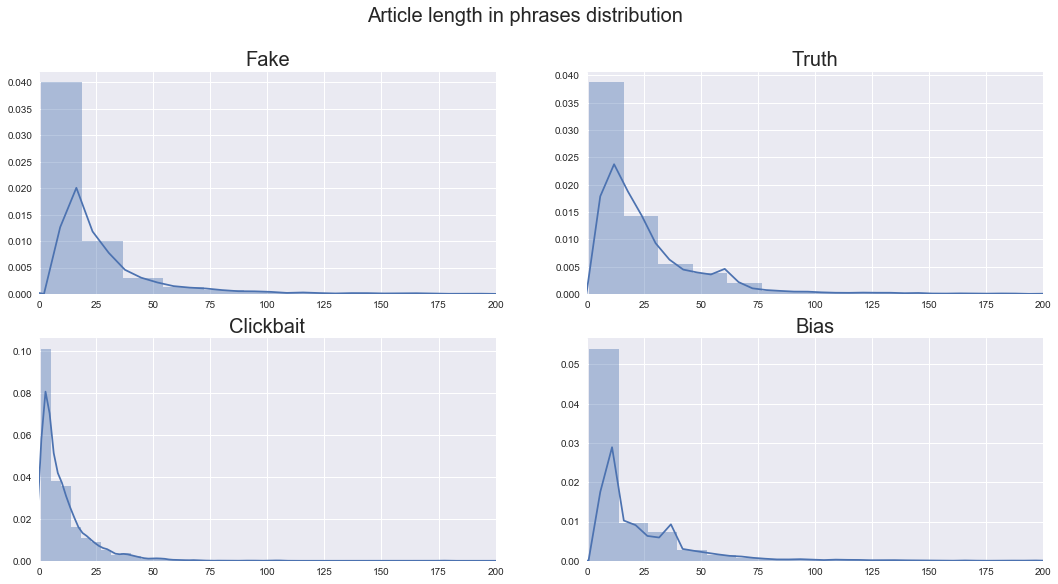

In [117]:
fig, ax = plt.subplots(2,2, figsize=(18,9))
fig.suptitle("Article length in phrases distribution", size=20)

sns.distplot(news[news['type']=='fake']['len_content'], ax=ax[0,0],)
ax[0,0].set_title("Fake", fontsize=20)
ax[0,0].set_xlabel("")
ax[0,0].set_xlim(0,200)

sns.distplot(news[news['type']=='truth']['len_content'], ax=ax[0,1])
ax[0,1].set_title("Truth", fontsize=20)
ax[0,1].set_xlabel("")
ax[0,1].set_xlim(0,200)

sns.distplot(news[news['type']=='click']['len_content'], ax=ax[1,0])
ax[1,0].set_title("Clickbait", fontsize=20)
ax[1,0].set_xlabel("")
ax[1,0].set_xlim(0,200)

sns.distplot(news[news['type']=='bias']['len_content'], ax=ax[1,1])
ax[1,1].set_title("Bias", fontsize=20)
ax[1,1].set_xlabel("")
ax[1,1].set_xlim(0,200)

plt.show()

**Signos de exclamación/interrogación por tipos de noticias**

In [57]:
news['len_content'] = news.content.str.count("!|\?")

Text(0.5,0.98,'')

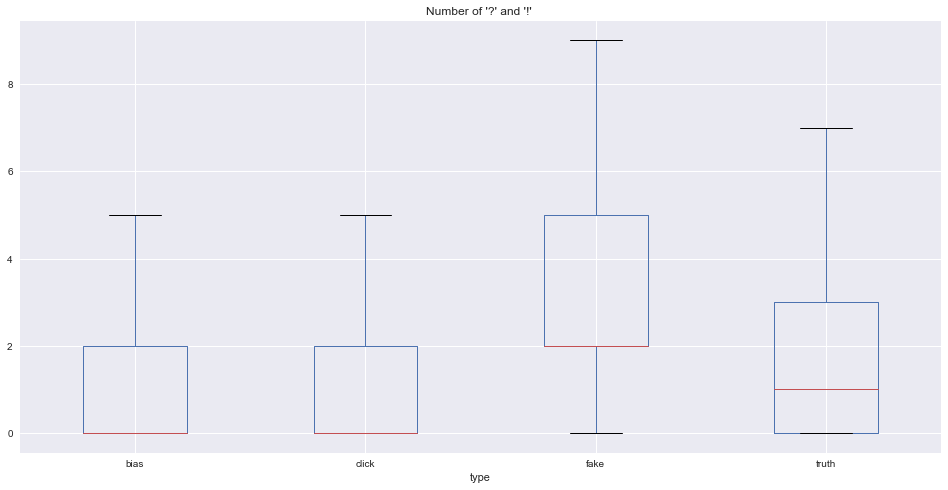

In [58]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Number of '?' and '!' ")
plt.suptitle("")

In [62]:
news=news.drop(['len_content'], axis=1)

## Análisis psicológico

Analizar las noticias por uso de personas:

* Primera persona: *I, me, my, mine, we, usk our, ours*
* Segunda persona: *you, you, your, yours*
* Tercera persona: *he, she, his, her, him, his, hers, they, them, their, theirs*

In [83]:
def count_person_forms(text, person):
    """
    Cuenta las ocurrencias de los tokens de person en el texto
    """
    text = tokenize(text.lower())
    counter = 0
    for word in text:
        if word in person:
            counter += 1
    return counter       

Pandas Apply: 100%|██████████| 19275/19275 [00:05<00:00, 3322.29it/s]


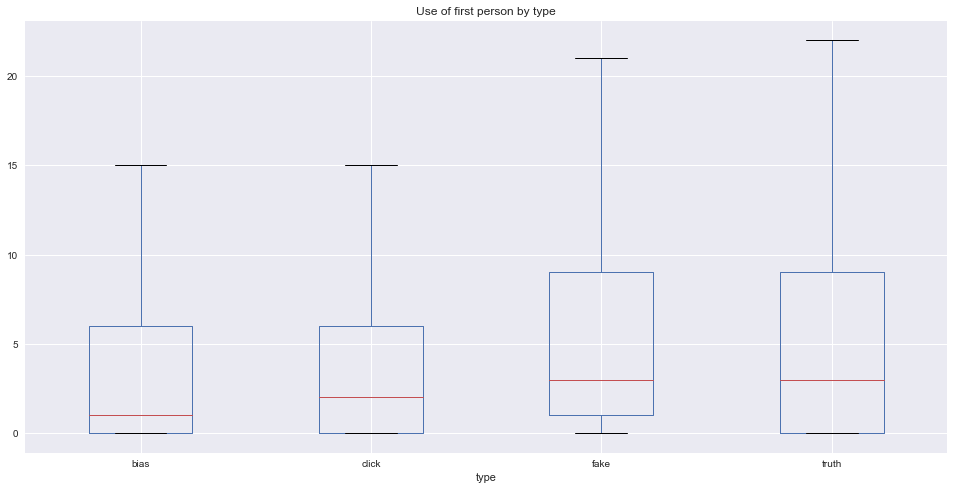

In [84]:
first_person = ["i", "me", "mine", "we", "us", "our", "ours"]
second_person = ["you", "your", "yours"]

news['first_person'] = news.swifter.apply(lambda row: count_person_forms(row['content'], first_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['first_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of first person by type")
fig.suptitle("")
plt.show()

In [85]:
news.groupby('type')['first_person'].mean()

type
bias     6.454151
click    4.555270
fake     8.158928
truth    7.841180
Name: first_person, dtype: float64

Pandas Apply: 100%|██████████| 19275/19275 [00:05<00:00, 3625.32it/s]


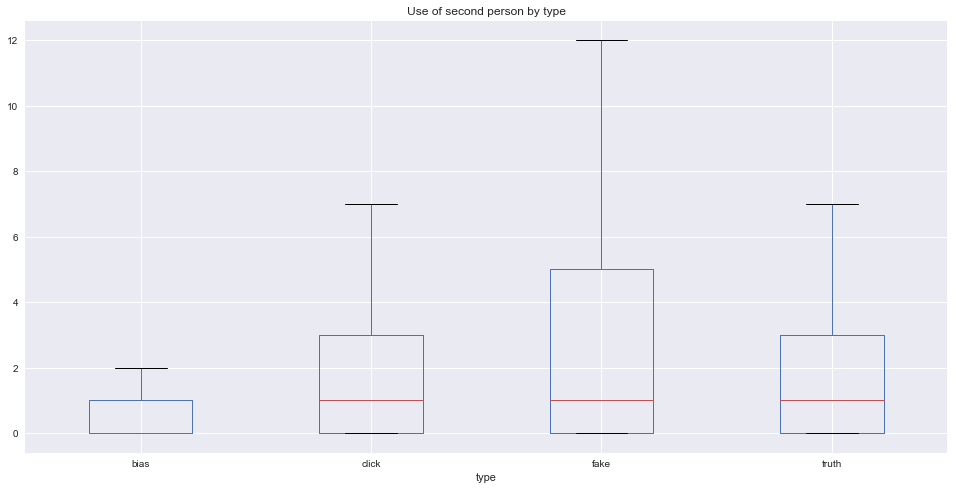

In [86]:
news['second_person'] = news.swifter.apply(lambda row: count_person_forms(row['content'], second_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['second_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of second person by type")
fig.suptitle("")
plt.show()

In [87]:
news=news.drop(['first_person'], axis=1)
news=news.drop(['second_person'], axis=1)

## Análisis de sentimiento

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [60]:
def classify_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    text = text.replace("\n\n", ". ").replace("\n", ". ")
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    pol = sid.polarity_scores(text)['compound']
    return pol

In [61]:
news['sent'] = news.swifter.apply(lambda r: classify_sentiment(r['content']), axis=1)

Pandas Apply: 100%|██████████| 81252/81252 [20:41<00:00, 65.42it/s]


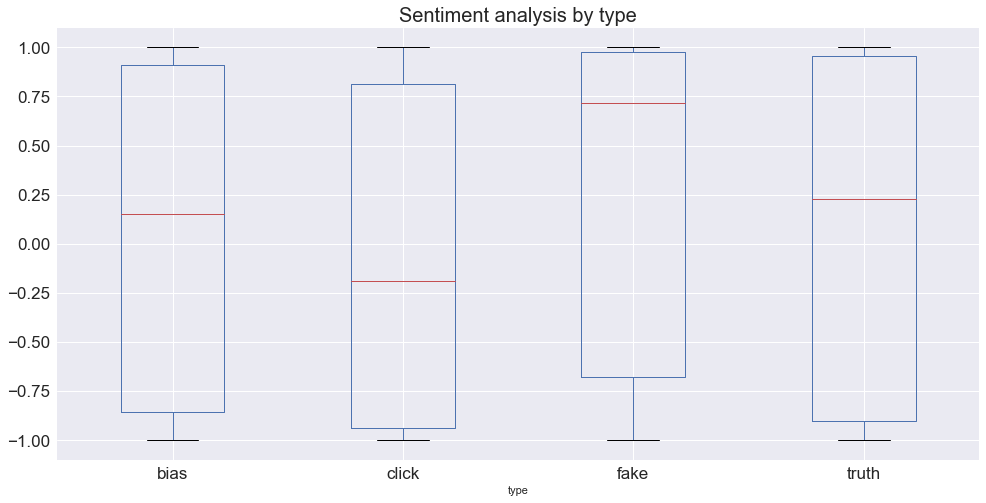

In [102]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['sent'], by='type', ax=ax, showfliers=False, fontsize=17)
ax.set_title("Sentiment analysis by type", fontsize=20)
fig.suptitle("")
plt.show()

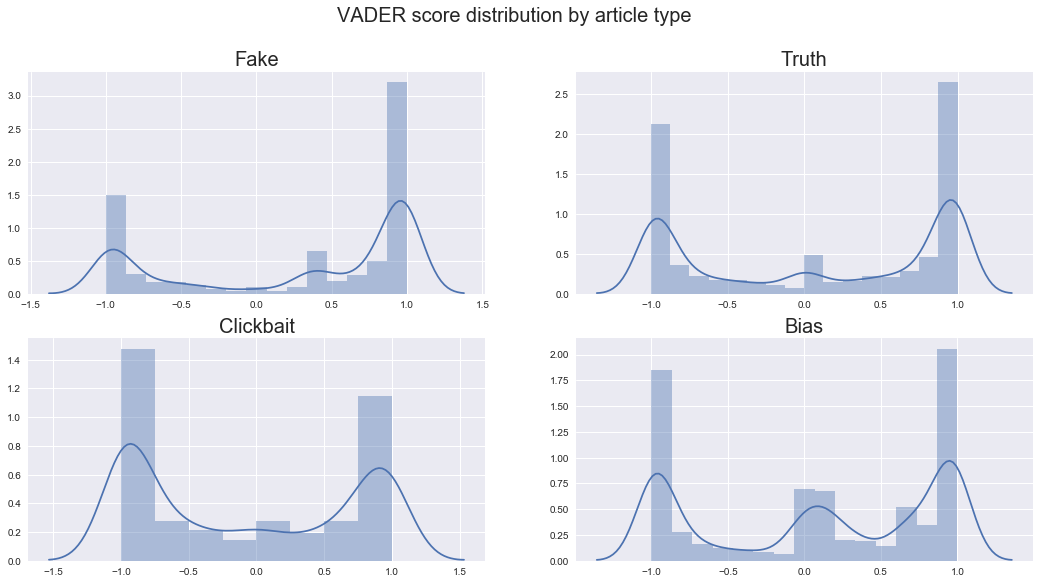

In [112]:
fig, ax = plt.subplots(2,2, figsize=(18,9))
fig.suptitle("VADER score distribution by article type", size=20)

sns.distplot(news[news['type']=='fake']['sent'], ax=ax[0,0],)
ax[0,0].set_title("Fake", fontsize=20)
ax[0,0].set_xlabel("")


sns.distplot(news[news['type']=='truth']['sent'], ax=ax[0,1])
ax[0,1].set_title("Truth", fontsize=20)
ax[0,1].set_xlabel("")

sns.distplot(news[news['type']=='click']['sent'], ax=ax[1,0])
ax[1,0].set_title("Clickbait", fontsize=20)
ax[1,0].set_xlabel("")

sns.distplot(news[news['type']=='bias']['sent'], ax=ax[1,1])
ax[1,1].set_title("Bias", fontsize=20)
ax[1,1].set_xlabel("")

plt.show()



## Análisis de diversidad de vocabulario

$ l = \frac {|t|}{|T|}$

Siendo
* $t$ el texto
* $T$ el conjunto de palabras (sin repetición) en el texto

In [74]:
def lexical_diversity(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = tokenize(text.lower())
    return len(set(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

In [75]:
news['lexical_diver'] = news.swifter.apply(lambda r: lexical_diversity(r['content']), axis=1)

Pandas Apply: 100%|██████████| 19275/19275 [00:05<00:00, 3538.63it/s]


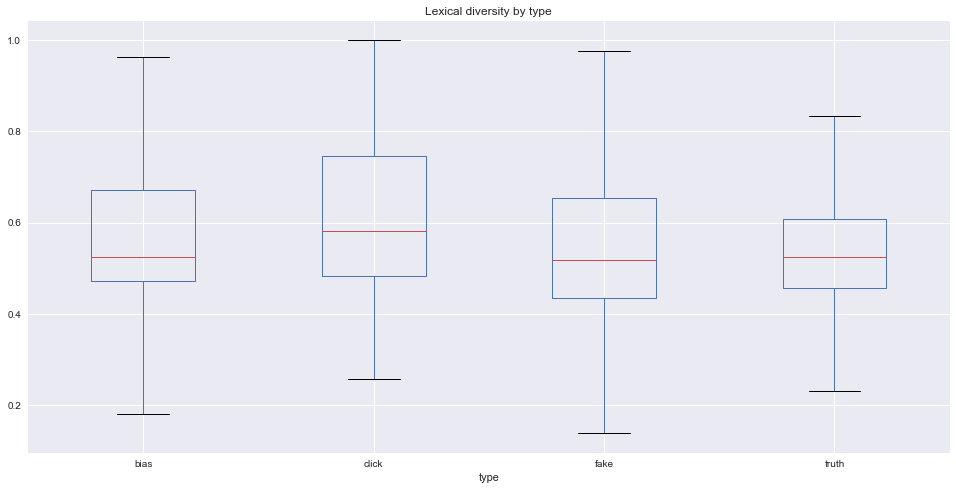

In [82]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax = news.boxplot(column=['lexical_diver'], by='type', ax=ax, showfliers=False)
ax.set_title("Lexical diversity by type")
fig.suptitle("")
plt.show()

In [85]:
news.groupby('type')['lexical_diver'].mean()

type
bias     0.570172
click    0.611938
fake     0.553289
truth    0.553283
Name: lexical_diver, dtype: float64